<br>

# Elongate Twitter Interaction Networks



<br>

## Environment setup & Data Import

In [1]:
# dependencies
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(pd.__version__)

1.4.2


In [3]:
print(pickle.format_version)

4.0


In [4]:
# importing twitter data
file = open("elonmusktwitter_tweets_df.obj",'rb')
df = pickle.load(file)
file.close()

In [5]:
# check structure
# reformat 'date' from string the datetime type
df['date'] =  pd.to_datetime(df['date'])
print( df.shape )
df.info()

(1475486, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475486 entries, 0 to 1475485
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   date                 1475486 non-null  datetime64[ns, UTC]
 1   id                   1475486 non-null  object             
 2   user_ID              1475486 non-null  object             
 3   user_name            1475486 non-null  object             
 4   user_location        1475486 non-null  object             
 5   content              1475486 non-null  object             
 6   lang                 1475486 non-null  object             
 7   replyCount           1475486 non-null  object             
 8   retweetCount         1475486 non-null  object             
 9   likeCount            1475486 non-null  object             
 10  inReplyToTweetId     673539 non-null   object             
 11  inReplyToUser_ID     1475486 non-nul

In [6]:
df.head()

,date,id,user_ID,user_name,user_location,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser_ID,inReplyToUser_name,mentionedUsers_ID,mentionedUsers_name
0,2022-04-01 23:52:46+00:00,1510042521300307970,1506615071891689475,indiaExam12,"Fatehabad, Haryana",Twitter Brings Back Elon Musk’s Horror Show on...,en,0,0,0,NaN,0,0,0,0
1,2022-04-01 23:51:26+00:00,1510042183092649990,1497034745573781520,agent_x23,"Oneonta, New York",@Sublux8tor @iOfRome72 @Tweets4retweets @tesla...,en,0,0,1,1510040892148645888.0,1025107839080001537,Sublux8tor,"[1025107839080001537, 1494906005523775489, 145...","[Sublux8tor, iOfRome72, Tweets4retweets, tesla..."
2,2022-04-01 23:48:22+00:00,1510041411474837504,1493816517514993667,Tyrone4Tyrone,,"@thestanceman1 @elonmusk Sure, I chastised a b...",en,0,0,1,1507795059600764928.0,1123267215678160901,thestanceman1,"[1123267215678160901, 44196397]","[thestanceman1, elonmusk]"
3,2022-04-01 23:46:45+00:00,1510041004983963652,1466802565148983307,Brandon36054793,,@Twitter Work on a control+alt+delete :) @elon...,en,0,0,0,1509951255388504064.0,783214,Twitter,"[783214, 44196397]","[Twitter, elonmusk]"
4,2022-04-01 23:42:52+00:00,1510040029917110280,1356021036127404034,ThomasHBradford,The Metaverse,@SamTwits @robustus @elonmusk lol why do peopl...,en,0,0,0,1509344789115940864.0,1646555828,SamTwits,"[1646555828, 14144398, 44196397]","[SamTwits, robustus, elonmusk]"


<br>

## Extracting Interaction Networks

In [7]:
# instantiate network digraphs
G_reply = nx.DiGraph()
G_mention = nx.DiGraph()

In [8]:
# a for loop to iterrate over
for idx in range(0, df.shape[0]):
    
    # tweet metadata
    author = df.iloc[idx]['user_name']
    timestamp = df.iloc[idx]['date']
        
    # remove duplicate retweets and mentions
    reply = df.iloc[idx]['inReplyToUser_name']
    mentions = df.iloc[idx]['mentionedUsers_name']
            
    # if there are retweeted or mentioned users add edges
    if reply !=0:
        if (author,reply) not in G_reply.edges():
            G_reply.add_edge( author, reply, Timestamp = timestamp )
    if mentions:      
        for user in mentions:
            if (author,user) not in G_mention.edges():
                G_mention.add_edge( author, user, Timestamp = timestamp )    

In [9]:
df_reply = nx.to_pandas_edgelist(G_reply)
print( df_reply.shape )
df_mention = nx.to_pandas_edgelist(G_mention)
print( df_mention.shape )

(595203, 3)
(1725092, 3)


In [10]:
df_reply.to_csv('elonmusktwitter_reply.csv', index=False)
df_mention.to_csv('elonmusktwitter_mention.csv', index=False) 

<br>

## Comparing the Reply and Mention Networks

### Basic Global Measures

In [15]:
df = pd.DataFrame([[len(G_reply.nodes), round(len(G_mention.nodes),0)],
                   [len(G_reply.edges), len(G_mention.edges)],
                   [nx.density(G_reply), nx.density(G_mention)]],
                  index=pd.Index(['Number of Nodes', 'Number of Edges', 'Density']),
                  columns=['Reply', 'Mention'])
df.style

,Reply,Mention
Number of Nodes,497639.000000,732244.000000
Number of Edges,595203.000000,1725092.000000
Density,0.000002,0.000003


* The Mention network is larger than the Reply network. This make the most sense as a given tweet can only be in reply to one user whereas a user can mention as many other users as the tweet character limit will allow.
* Both networks are very sparse with only a fraction of a percent of the possible edge connection made.

### Degree Analysis

adapt the code from [NetworkX Degree Analysis](https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html) example to visualize connectivity between the two networks. This will allow us the look for patterns in the connectivity of the nodes for each network

In [85]:
# find the degree connectivity of nodes in the network
#in reply
reply_indegree_sequence = sorted((d for n, d in G_reply.in_degree()), reverse=True)
in_reply_dmax = max(reply_indegree_sequence)
#in mention
mention_indegree_sequence = sorted((d for n, d in G_mention.in_degree()), reverse=True)
in_mention_dmax = max(mention_indegree_sequence)
#out reply
reply_outdegree_sequence = sorted((d for n, d in G_reply.out_degree()), reverse=True)
out_reply_dmax = max(reply_outdegree_sequence)
#out mention
mention_outdegree_sequence = sorted((d for n, d in G_mention.out_degree()), reverse=True)
out_mention_dmax = max(mention_outdegree_sequence)

df = pd.DataFrame([[in_reply_dmax, in_mention_dmax],
                  [out_reply_dmax, out_mention_dmax]],
                  index=pd.Index(['Max In-Degree', 'Max Out-Degree']),
                  columns=['Reply', 'Mention'])
df.style

,Reply,Mention
Max In-Degree,119145,529067
Max Out-Degree,148,428


In [102]:
# Create a gridspec for adding subplots of different sizes
def plot_network_deg( network_str, in_degree_sequence, out_degree_sequence ):
    """
    plot the degree rank plot and degree distribution plot
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
    #in degree rank plot
    ax1.loglog(in_degree_sequence, "b-", marker="o")
    ax1.set_title("In-Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    #in degee distribution
    ax2.hist(in_degree_sequence, bins=50, range=(0,50))
    ax2.set_title("In-Degree Distribution")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    #out degree rank plot
    ax3.loglog(out_degree_sequence, "b-", marker="o")
    ax3.set_title("Out-Degree Rank Plot")
    ax3.set_ylabel("Degree")
    ax3.set_xlabel("Rank")
    #out degee distribution
    ax4.hist(out_degree_sequence, bins=50, range=(0,50))
    ax4.set_title("Out-Degree Distribution")
    ax4.set_xlabel("Degree")
    ax4.set_ylabel("# of Nodes")    

    plt.setp(ax3, ylim=ax1.get_ylim())
    plt.setp(ax4, ylim=ax2.get_ylim())
#     fig.tight_layout()
    fig.suptitle(network_str)
    plt.show()

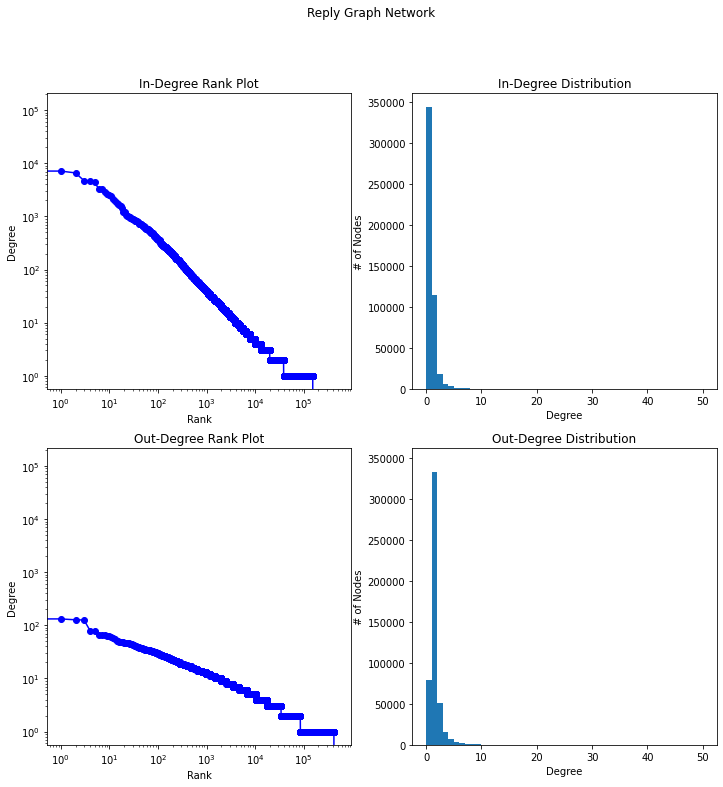

In [103]:
plot_network_deg( 'Reply Graph Network', reply_indegree_sequence, reply_outdegree_sequence )

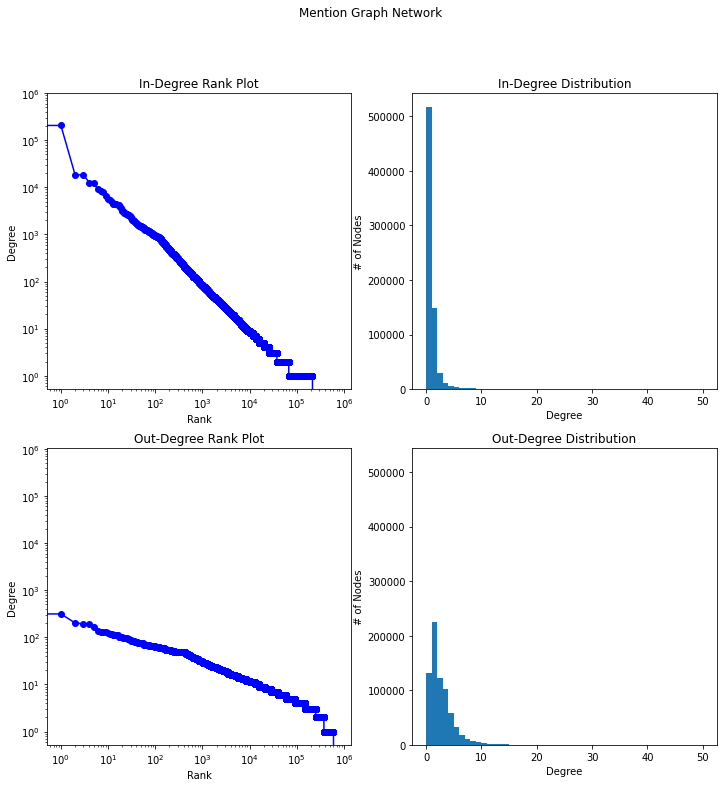

In [104]:
plot_network_deg( 'Mention Graph Network', mention_indegree_sequence, mention_outdegree_sequence )

There is a similar pattern for each of the graph networks:
* **In-Degree ~ Rank Plot** - where rank sequence == Node connectivity that appears the least frequent ordered first and node connectivity that appears the most, last.
    - nodes that have a very high connectivity appear the least
    - nodes with a very low connectivity appear most frequently
* **In-Degree Distribution** 
    - The vast majority of nodes in he data set have very low degree connectivity.
* **Out-Degree ~ Rank Plot**
    - For both networks, this plot is shallower than the In-Degree owing to the shorter range of possible values
* **Out-Degree Distribution**
    - Out degree distribution is shifted slightly to the right compared to the In-Degree Distribution; this is more pronounced in the Mention graph network

Interesting. Now to take a look at the user names behings some of the nodes with the most In-bound replies vs the outbound. Likewise for Mentions  

In a data set built on the query 'elon musk twitter', which name will recieve the most replies and mentions?

In [105]:
reply_indegree = [[n,d] for n, d in G_reply.in_degree()]
res =(sorted(reply_indegree, key=lambda x:x[1], reverse=True))
print( '\nTop In-Degree Reply Network Nodes:' )
res[0:10]


Top In-Degree Reply Network Nodes:


[['elonmusk', 119145],
 ['TomFitton', 7135],
 ['tedcruz', 6591],
 ['CawthornforNC', 4707],
 ['MulhollandL0ver', 4553],
 ['JRlopezbeltran', 4392],
 ['marcorubio', 3275],
 ['laurenboebert', 3235],
 ['ClayTravis', 2880],
 ['beppesevergnini', 2639]]

In [106]:
reply_outdegree = [[n,d] for n, d in G_reply.out_degree()]
res =(sorted(reply_outdegree, key=lambda x:x[1], reverse=True))
print( '\nTop Out-Degree Reply Network Nodes:' )
res[0:10]


Top Out-Degree Reply Network Nodes:


[['macgyver_p', 148],
 ['writerlyai_bot', 132],
 ['elonmusk', 127],
 ['SergioVengeance', 126],
 ['JeffreyAWillia4', 79],
 ['Factschaser', 78],
 ['GyroWaveGen_TM', 66],
 ['Cartel36661994', 66],
 ['SheldonCassidy2', 65],
 ['claes69', 64]]

In [107]:
mention_indegree = [[n,d] for n, d in G_mention.in_degree()]
res =(sorted(mention_indegree, key=lambda x:x[1], reverse=True))
print( '\nTop In-Degree Mention Network Nodes:' )
res[0:10]


Top In-Degree Mention Network Nodes:


[['elonmusk', 529067],
 ['Twitter', 205863],
 ['Alwaleed_Talal', 18490],
 ['Kingdom_KHC', 18326],
 ['TomFitton', 12639],
 ['paraga', 12429],
 ['Tesla', 9117],
 ['jack', 8552],
 ['tedcruz', 7890],
 ['YouTube', 6488]]

In [108]:
mention_outdegree = [[n,d] for n, d in G_mention.out_degree()]
res =(sorted(mention_outdegree, key=lambda x:x[1], reverse=True))
print( '\nTop Out-Degree Mention Network Nodes:' )
res[0:10]


Top Out-Degree Mention Network Nodes:


[['scharlab', 428],
 ['SergioVengeance', 314],
 ['macgyver_p', 202],
 ['elonmusk', 194],
 ['Factschaser', 193],
 ['digital_slime', 168],
 ['stratorob', 134],
 ['NewStyle303', 131],
 ['writerlyai_bot', 130],
 ['iJaceSummers', 128]]

* For both the Reply and Mention networks, the number of In-degree edges for the top ranked nodes is orders of magnitudes greater than the Out-degree edges for the top ranked nodes
* For this small sample of 10: The top Reply nodes tend to be to identifiably human accounts. Whereas the Mentions have several organizations (e.g. Twitter, Tesla & Youtube) at least for In-degree.